# 集成学习
集成学习按基模型的生成方式和基模型的整合方式aggregate可分类以下3类：
- bagging  
    - 同一基模型，不同的子训练集subsample； 整合方式有多数投票
- boosting
    - 同一基模型算法，不同权重的训练集；加权平均
- stacking
    - 不同基模型算法，同一训练数据；整合方式是带正则化项的线性回归，或者是聚类

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = 'SimHei'

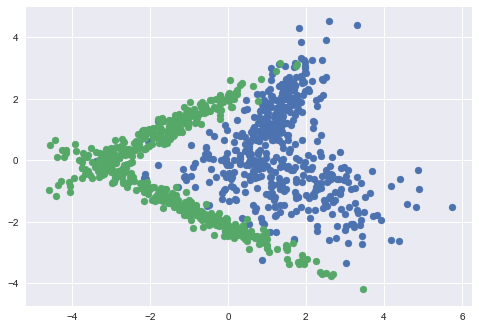

In [145]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,cross_val_predict
from sklearn.pipeline import make_pipeline, Pipeline
from Chemometrics.utils import plot_PCA, timer, plot_cm
import inspect
inspect.signature(make_classification)

seed = 3
np.random.seed(seed)
X, y = make_classification(n_samples=1000, random_state=seed)
pca = plot_PCA(X, y)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

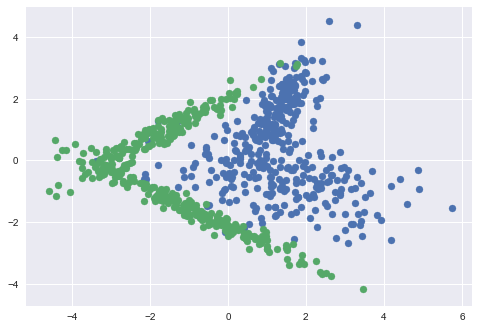

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
plot_PCA(X_train, y_train, pca=pca)

## 1. bagging
### 1.1 bagging classifier

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [24]:
lr = LogisticRegression()
cv = 5 
param_lr = {'C': np.power(2., range(-5, 5))}
grid_lr = GridSearchCV(lr, param_grid=param_lr, cv=cv)
grid_lr = grid_lr.fit(X_train, y_train)
grid_lr.best_params_

{'C': 0.03125}

In [25]:
with timer('train bagged lr'):
    bag = BaggingClassifier(base_estimator=lr, 
                            max_samples=.5, 
                            max_features=.5,
                            random_state=seed)
    param_bag = {'max_samples': np.arange(.3, .8, .1),
                'n_estimators': range(2, 12),
                'max_features': np.arange(.3, .8, .1)}
    grid_bag = GridSearchCV(bag, param_grid=param_bag, cv=cv).fit(X_train, y_train)
print(grid_bag.best_params_)
print(grid_bag.best_score_)

train bagged lr starts
train bagged lr done in 32.42s
{'max_features': 0.3, 'max_samples': 0.5, 'n_estimators': 5}
0.8773333333333333


lr accuracy: [0.85430464 0.86092715 0.85333333 0.90604027 0.8590604 ]
bagged lr accuracy: [0.86092715 0.86092715 0.86666667 0.90604027 0.89261745]


[[<matplotlib.text.Text at 0x1957ef712b0>,

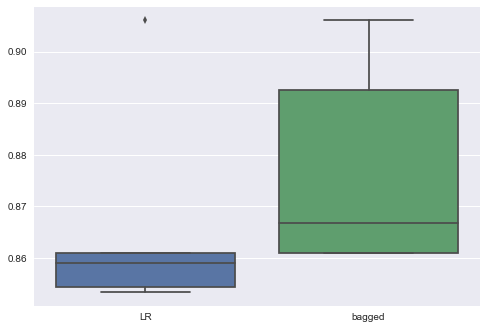

In [26]:
# baseline
baseline = cross_val_score(grid_lr, X_train, y_train, cv=cv)
print(f'lr accuracy: {baseline}')
bagged = cross_val_score(grid_bag.best_estimator_, X_train, y_train, cv=cv)
print(f'bagged lr accuracy: {bagged}')
fig = sns.boxplot(data = np.vstack([baseline,bagged]).T)
fig.set(xticklabels=['LR', 'bagged'])

In [27]:
from sklearn.metrics import classification_report
lr_pred = grid_lr.predict(X_test)
print(classification_report(y_test, lr_pred))

             precision    recall  f1-score   support

          0       0.83      0.88      0.86       121
          1       0.88      0.83      0.86       129

avg / total       0.86      0.86      0.86       250



In [28]:
bag_pred = grid_bag.predict(X_test)
print(classification_report(y_test, bag_pred))

             precision    recall  f1-score   support

          0       0.87      0.91      0.89       121
          1       0.91      0.87      0.89       129

avg / total       0.89      0.89      0.89       250



可以看出bagging可以:
1. 减小模型的方差
2. 略微提升模型的accuracy

控制c好点?

### 1.2 random forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
inspect.signature(RandomForestClassifier)

<Signature (n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)>

In [11]:
with timer('train random forest'):
    rf = RandomForestClassifier(random_state=seed, n_jobs=1)
    params = {'n_estimators': range(25, 35, 1), 
              'min_samples_split': range(2, 7),
              'max_depth': range(9, 14)}
    grid_rf = GridSearchCV(rf, param_grid=params, cv=cv).fit(X_train, y_train)
    cross_val_score(grid_rf.best_estimator_, X_train, y_train)
    print(grid_rf.best_params_)

train random forest starts
{'max_depth': 12, 'min_samples_split': 4, 'n_estimators': 28}
train random forest done in 183.34s


In [29]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=seed)
inspect.signature(DecisionTreeClassifier)

<Signature (criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_split=1e-07, class_weight=None, presort=False)>

In [30]:
with timer('train decision tree'):
    params_dt = {'min_samples_split': range(2, 15), 'max_depth': range(2,10)}
    grid_dt = GridSearchCV(dt, param_grid=params_dt, cv=cv).fit(X_train, y_train)
    print(grid_dt.best_params_)

train decision tree starts
{'max_depth': 4, 'min_samples_split': 9}
train decision tree done in 4.72s


[[<matplotlib.text.Text at 0x1957eff0978>,

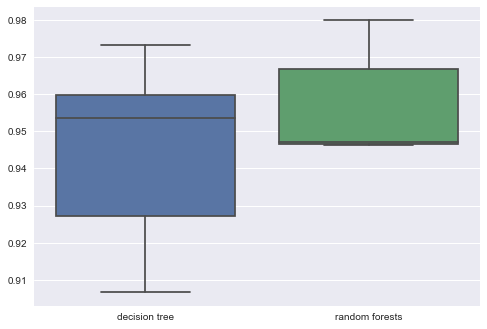

In [31]:
dt_ = cross_val_score(grid_dt.best_estimator_, X_train, y_train, cv=cv)
rf_ = cross_val_score(grid_rf.best_estimator_, X_train, y_train, cv=cv)
sns.boxplot(data=np.vstack([dt_, rf_]).T)
plt.gca().set(xticklabels=['decision tree', 'random forests'])

In [22]:
pred_dt = grid_dt.predict(X_test)
print(classification_report(y_test, pred_dt))
# plot_cm(y_test, pred_dt)

             precision    recall  f1-score   support

          0       0.97      0.93      0.95       121
          1       0.94      0.98      0.96       129

avg / total       0.96      0.96      0.96       250



In [23]:
rf_pred= grid_rf.predict(X_test)
print(classification_report(y_test, rf_pred))

             precision    recall  f1-score   support

          0       0.97      0.93      0.95       121
          1       0.93      0.97      0.95       129

avg / total       0.95      0.95      0.95       250



同样可以看出random forests相比于decision tree:
- 模型效果没有提升
- 降低了模型的方差

另外，树模型相比于线性的LR模型效果大幅提高6%

<Container object of 20 artists>

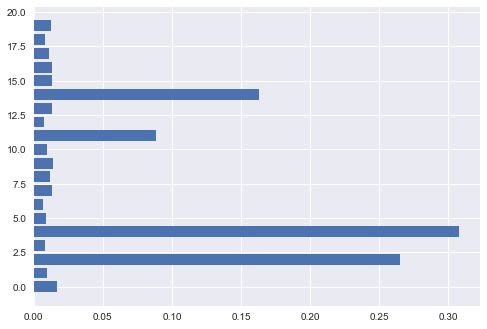

In [17]:
plt.barh(range(X.shape[1]), grid_rf.best_estimator_.feature_importances_)

In [18]:
inspect.signature(make_classification)

<Signature (n_samples=100, n_features=20, n_informative=2, n_redundant=2, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)>

从random forests模型的特征重要性可以看出：
- 有4个特征比较重要， 对应的是 n_informative + n_redundant   
如果不shuffle的话， 会是前4个

#### 1.2.2 extremely randomizer tree
todo

## 2.  boosting

### 2.1 Adaboost
指数损失 ==》 错误率 ==》 信息增益

In [39]:
from sklearn.ensemble import AdaBoostClassifier
inspect.signature(AdaBoostClassifier)

<Signature (base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)>

In [44]:
base_dt = DecisionTreeClassifier(max_depth=1)
ada = AdaBoostClassifier(base_dt, random_state=seed)
params = {'n_estimators':range(10,100,2)}
with timer('train Adabooost'):
    grid_ada = GridSearchCV(ada, param_grid=params, cv=cv).fit(X_train, y_train)
grid_ada.best_params_

train Adabooost starts
train Adabooost done in 50.24s


{'n_estimators': 30}

[[<matplotlib.text.Text at 0x1957f202748>,

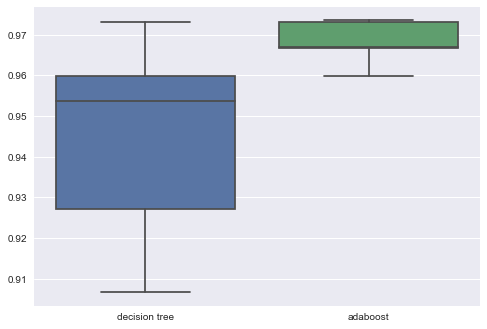

In [45]:
dt_ = cross_val_score(grid_dt.best_estimator_, X_train, y_train, cv=cv)
ada_ = cross_val_score(grid_ada.best_estimator_, X_train, y_train, cv=cv)
sns.boxplot(data=np.vstack([dt_, ada_]).T)
plt.gca().set(xticklabels=['decision tree', 'adaboost'])

In [48]:
pred_dt = grid_dt.predict(X_test)
print(classification_report(y_test, pred_dt))
ada_pred= grid_ada.predict(X_test)
print(classification_report(y_test, ada_pred))

             precision    recall  f1-score   support

          0       0.97      0.93      0.95       121
          1       0.94      0.98      0.96       129

avg / total       0.96      0.96      0.96       250

             precision    recall  f1-score   support

          0       0.97      0.94      0.95       121
          1       0.95      0.97      0.96       129

avg / total       0.96      0.96      0.96       250



可以看出当base_dt的max_depth为1时
- adaboost交叉验证效果好于决策树
- 并且方差较小  
另外一个现象是当不限制基模型决策树的深度时，效果差于决策树  
还有用cross_val_predict来验证只能得到bias, 无法估计variance, test_set也无法估计variance

<Container object of 20 artists>

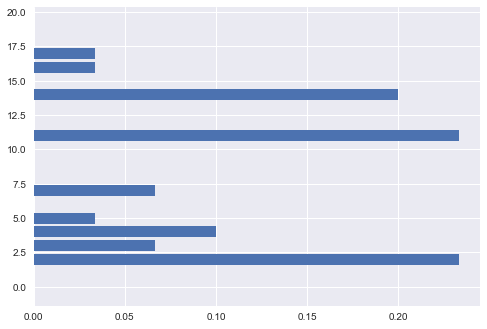

In [51]:
plt.barh(range(X.shape[1]), grid_ada.best_estimator_.feature_importances_)

特征重要性是特征在base里的重要性的加权平均

### 2.2 gradient boost machine

In [73]:
from sklearn.ensemble import GradientBoostingClassifier
print(inspect.signature(GradientBoostingClassifier))
gbdt = GradientBoostingClassifier(learning_rate=.1, 
                                  n_estimators=100, 
                                  subsample=.2, 
                                  max_depth=2, 
                                  random_state=seed,
                                  max_leaf_nodes=6)
params_gbdt = dict(n_estimators=np.arange(26,35), 
                  max_depth=range(3,7))
grid_gbdt = GridSearchCV(gbdt, param_grid=params_gbdt, cv=cv)
grid_gbdt = grid.fit(X_train, y_train)

(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_split=1e-07, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')


In [71]:
grid_gbdt.best_params_

{'max_depth': 4, 'max_leaf_nodes': 6, 'n_estimators': 30}

[[<matplotlib.text.Text at 0x1957f6ae978>,

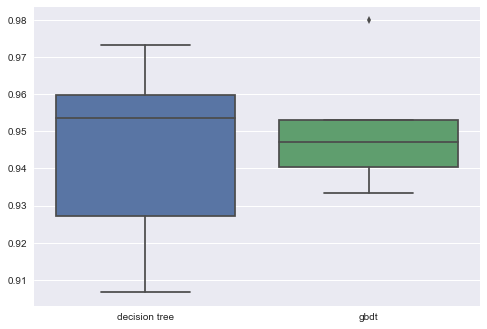

In [70]:
grid_gbdt = grid
dt_ = cross_val_score(grid_dt.best_estimator_, X_train, y_train, cv=cv)
gbdt_ = cross_val_score(grid_gbdt.best_estimator_, X_train, y_train, cv=cv)
sns.boxplot(data=np.vstack([dt_, gbdt_]).T)
plt.gca().set(xticklabels=['decision tree', 'gbdt'])

## 3. stacking
[A Kaggler's Guide to Model Stacking in Practice](http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/)

In [65]:
_X_train, X_vali, _y_train, y_vali = train_test_split(X_train, y_train)

# stacking 方式选择
1. train, vali, test
在train上训练lv1模型，lv1模型在vali上预测做为lv2的训练数据，用vali来训练lv2模型，最终用test来检验
2. train, test
在train上用交叉验证训练lv1模型，并cross_vali_predict生成新的train, 最后用新train来训练模型，并用test验证

In [91]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
params = {'C': np.power(2., range(-5,6))}
svc_grid = GridSearchCV(svc, param_grid=params, cv=cv)
svc_grid.fit(_X_train, _y_train)
svc_grid.best_score_

0.8558718861209964

In [92]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn_params = {'n_neighbors': range(2,30,2)}
knn_grid = GridSearchCV(knn, param_grid=knn_params)
knn_grid = knn_grid.fit(_X_train, _y_train)
print(knn_grid.best_score_)
knn_grid.best_params_

0.8825622775800712


{'n_neighbors': 20}

In [101]:
_X_vali = make_data(X_vali, [knn_grid, svc_grid])

In [154]:
lr = LogisticRegression()
lr_params = dict(C=np.power(2., range(-30,20)), penalty=['l1', 'l2'])
meta_grid = GridSearchCV(lr, param_grid=lr_params, cv=cv)
meta_grid = meta_grid.fit(_X_vali, y_vali)

In [155]:
meta_grid.best_params_

{'C': 9.313225746154785e-10, 'penalty': 'l2'}

[[<matplotlib.text.Text at 0x1957fa1d7b8>,

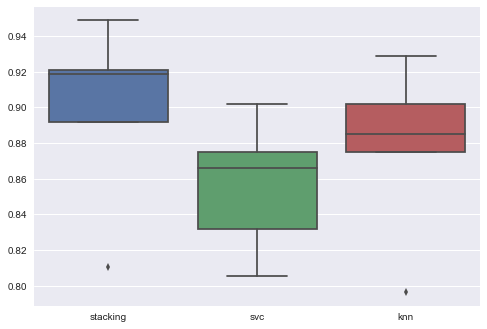

In [135]:
_meta = cross_val_score(meta_grid.best_estimator_, _X_vali, y_vali, cv=cv)
svc_ = cross_val_score(svc_grid.best_estimator_, _X_train, _y_train, cv=cv)
knn_ = cross_val_score(knn_grid.best_estimator_, _X_train, _y_train, cv=cv)
sns.boxplot(data=np.vstack([_meta, svc_, knn_]).T)
plt.gca().set(xticklabels=['stacking', 'svc', 'knn'])

In [136]:
np.median(_meta)

0.918918918918919

可以看出stacking还是有用的

In [161]:
def make_data(X, bases, y=None, cross=False, **kwargs):
    preds = [X]
    for base in bases:
        if cross:
            _pred = cross_val_predict(base, X, y, **kwargs)
        else:
            _pred = base.predict(X)
        preds.append(_pred[:, np.newaxis])
    _X = np.hstack(preds)
    return _X

In [138]:
_X_test= make_data(X_test, [knn_grid, svc_grid])

In [139]:
y_pred = meta_grid.predict(_X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.87      0.87      0.87       121
          1       0.88      0.88      0.88       129

avg / total       0.87      0.87      0.87       250



- 测试集预测准确率有点低

### stacking 方式2

In [162]:
svc_grid = svc_grid.fit(X_train, y_train)
knn_grid = knn_grid.fit(X_train, y_train)
X_train2= make_data(X_train, [knn_grid, svc_grid], y_train, cross=True, cv=cv)
X_test2= make_data(X_test, [knn_grid, svc_grid])

In [163]:
meta2 = meta_grid.fit(X_train2, y_train)

In [167]:
_meta2 = cross_val_score(meta2, X_train2, y_train, cv=cv)

[[<matplotlib.text.Text at 0x1957fdf3400>,

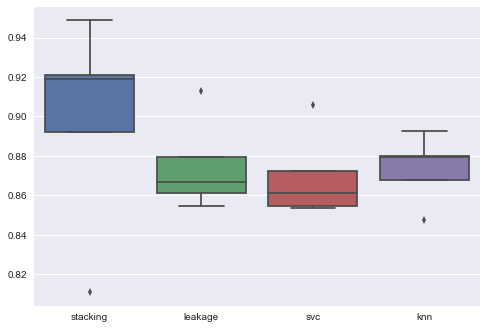

In [173]:
svc_ = cross_val_score(svc_grid.best_estimator_, X_train, y_train, cv=cv)
knn_ = cross_val_score(knn_grid.best_estimator_, X_train, y_train, cv=cv)
sns.boxplot(data=np.vstack([_meta, _meta2, svc_, knn_]).T)
plt.gca().set(xticklabels=['stacking','leakage', 'svc', 'knn'])

In [178]:
# make prediction

In [175]:
y_pred2 = meta2.predict(X_test2)
print(classification_report(y_test, y_pred2))

             precision    recall  f1-score   support

          0       0.83      0.90      0.87       121
          1       0.90      0.83      0.86       129

avg / total       0.87      0.86      0.86       250



- 从cross validation和test来看， 都是没有leakage会好点